Importación de Librerias necesarias.

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.impute import KNNImputer
import pandas as pd
from utils import db_connect
import missingno as msno
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
import xgboost as xgb
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, KernelPCA
from sklearn.model_selection import cross_val_score
from lazypredict.Supervised import LazyRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error

## Trabajaremos con la base de datos de Airbnb, de New York, para determinar los factores de importancia para predecir el precio de los inmuebles.

### Lectura Archivo

In [7]:
df = pd.read_csv('/workspaces/machine-learning/data/raw/AB_NYC_2019.csv').iloc[:,1:]

## Exploración y limpieza de datos

In [8]:
df.head(3)

,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.65,-73.97,Private room,149,1,9,2018-10-19,0.21,6,365
1,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75,-73.98,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.81,-73.94,Private room,150,3,0,NaN,NaN,1,365


Validar cantidad de columnas y filas

In [9]:
df.shape

(48895, 15)

Informacion General

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   name                            48879 non-null  object 
 1   host_id                         48895 non-null  int64  
 2   host_name                       48874 non-null  object 
 3   neighbourhood_group             48895 non-null  object 
 4   neighbourhood                   48895 non-null  object 
 5   latitude                        48895 non-null  float64
 6   longitude                       48895 non-null  float64
 7   room_type                       48895 non-null  object 
 8   price                           48895 non-null  int64  
 9   minimum_nights                  48895 non-null  int64  
 10  number_of_reviews               48895 non-null  int64  
 11  last_review                     38843 non-null  object 
 12  reviews_per_month               

Validamos si hay columnas con datos unicos, que no varian.

In [11]:
cont_unique = df.nunique()
cont_unique

name                              47905
host_id                           37457
host_name                         11452
neighbourhood_group                   5
neighbourhood                       221
latitude                          19048
longitude                         14718
room_type                             3
price                               674
minimum_nights                      109
number_of_reviews                   394
last_review                        1764
reviews_per_month                   937
calculated_host_listings_count       47
availability_365                    366
dtype: int64

Validamos que no haya duplicados

In [12]:
df.duplicated().sum()

0

In [13]:
df.describe()

,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,48895.00,48895.00,48895.00,48895.00,48895.00,48895.00,38843.00,48895.00,48895.00
mean,67620010.65,40.73,-73.95,152.72,7.03,23.27,1.37,7.14,112.78
std,78610967.03,0.05,0.05,240.15,20.51,44.55,1.68,32.95,131.62
min,2438.00,40.50,-74.24,0.00,1.00,0.00,0.01,1.00,0.00
25%,7822033.00,40.69,-73.98,69.00,1.00,1.00,0.19,1.00,0.00
50%,30793816.00,40.72,-73.96,106.00,3.00,5.00,0.72,1.00,45.00
75%,107434423.00,40.76,-73.94,175.00,5.00,24.00,2.02,2.00,227.00
max,274321313.00,40.91,-73.71,10000.00,1250.00,629.00,58.50,327.00,365.00


Como pudimos observar, hay inmuebles con un precio igual a 0, procedemos a eliminarlos ya que no aportan informacion relevante en este caso.


In [14]:
df = df[df['price'] != 0]

#### Eliminamos información irrelevante.
esto con el objetivo de tener información que el algoritmo si podria utilizar.

In [15]:
df.drop(["host_id","number_of_reviews","reviews_per_month", "name", "host_name", "last_review"], axis = 1, inplace= True)

In [16]:
df.describe()

,latitude,longitude,price,minimum_nights,calculated_host_listings_count,availability_365
count,48884.00,48884.00,48884.00,48884.00,48884.00,48884.00
mean,40.73,-73.95,152.76,7.03,7.14,112.78
std,0.05,0.05,240.17,20.51,32.96,131.63
min,40.50,-74.24,10.00,1.00,1.00,0.00
25%,40.69,-73.98,69.00,1.00,1.00,0.00
50%,40.72,-73.96,106.00,3.00,1.00,45.00
75%,40.76,-73.94,175.00,5.00,2.00,227.00
max,40.91,-73.71,10000.00,1250.00,327.00,365.00


## Grafica de variables

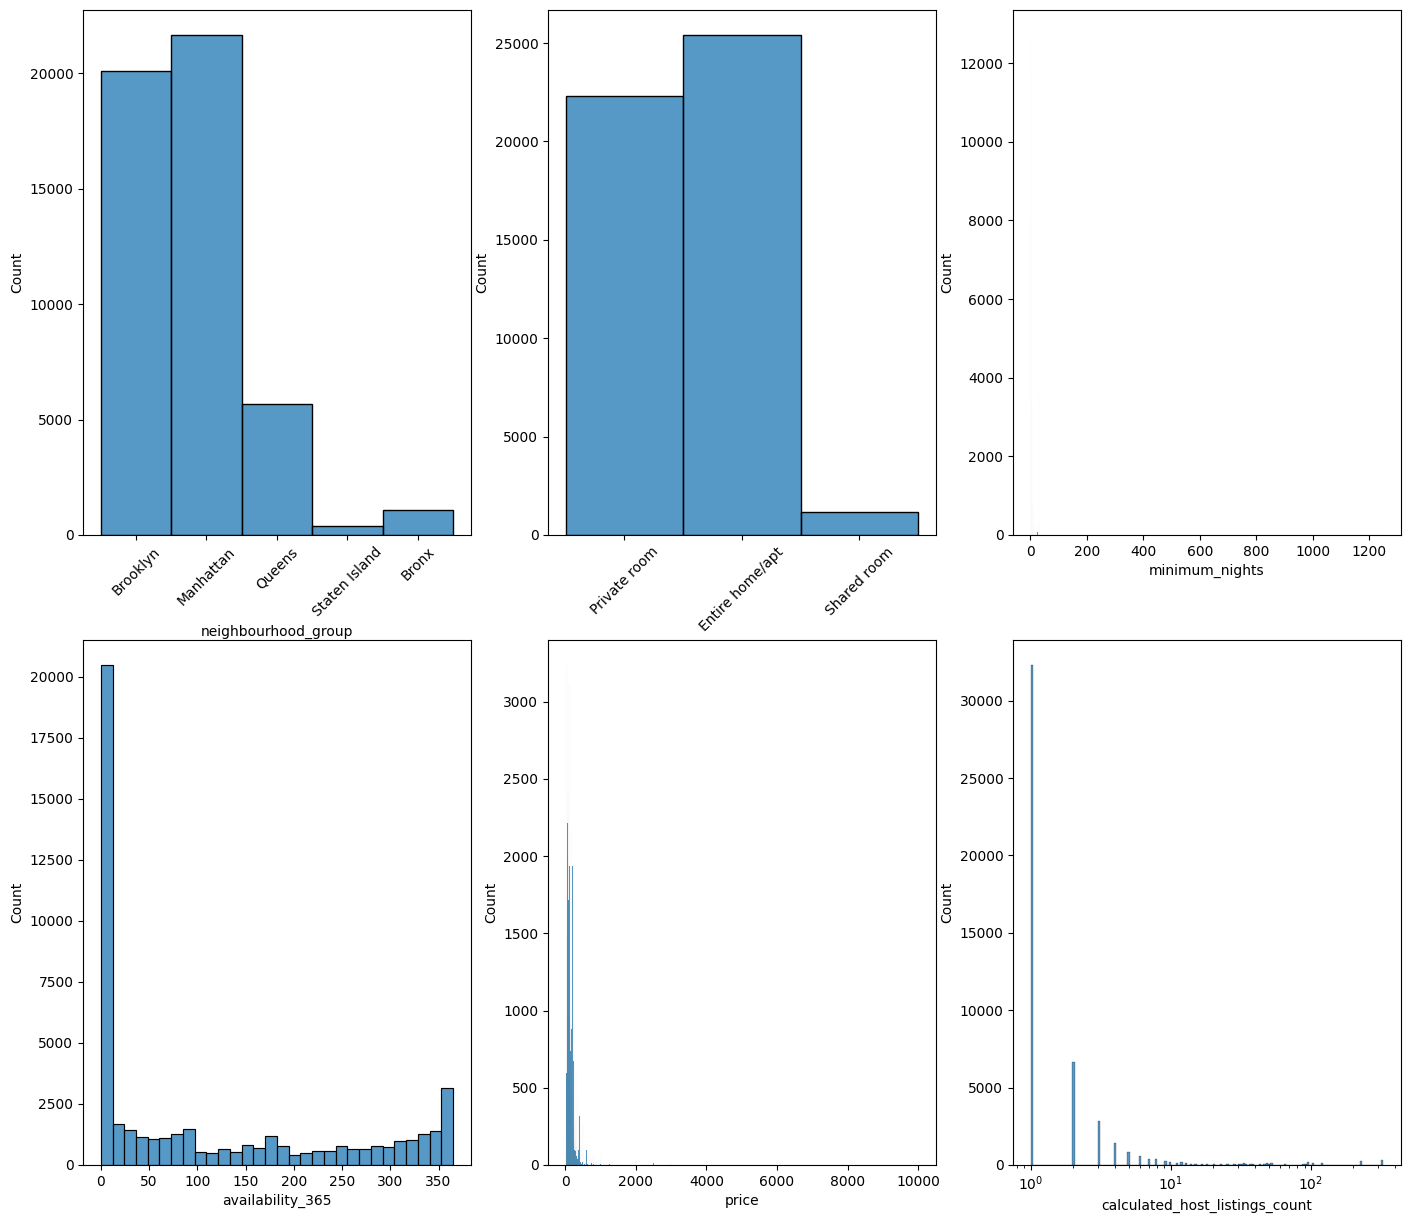

In [17]:
fig, axis = plt.subplots(2,3 , figsize=(17,15))
sns.histplot( ax = axis[0,0], data = df, x= "neighbourhood_group")
axis [0] [0].set_xticklabels (axis [0] [0].get_xticklabels (), rotation=45)
sns.histplot( ax = axis[0,1], data = df, x= "room_type")
axis [0] [1].set_xticklabels (axis [0] [1].get_xticklabels (), rotation=45)
sns.histplot( ax = axis[0,2], data = df, x= "minimum_nights")
sns.histplot( ax = axis[1,0], data = df, x= "availability_365")
sns.histplot( ax = axis[1,1], data = df, x= "price")
sns.histplot( ax = axis[1,2], data = df, x= "calculated_host_listings_count", log_scale=True)


plt.tight_layout
plt.show()

## Análisis: 
    
    1. Podemos observar de entrada que los valores en el caso de precio y minimo de noches, son asimetricos, por lo que debemos indagar si esa informacion nos es de utilidad, si tiene alguna importancia.
    2. Disponibilidad tenemos que la gran mayoria de los casos es inferior a 100.
    3. La zonas con mayor disponibilidad es Manhattan seguido de Brooklyn,representando mas del 60% de los avisos publicados.
    4. Tipo de Habitacion tiene una tendencia casi absoluta en la que la incidencia de Habitacion privada y Piso completo es casi absoluta, dejando a Habitacion Compartida con muy pocas publicaciones.
    


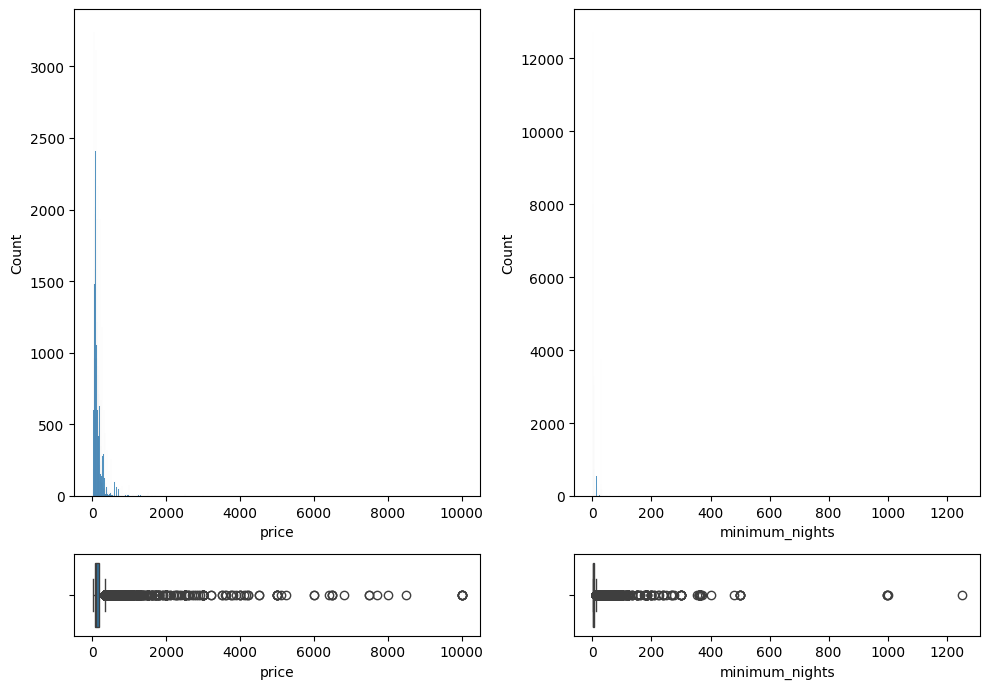

In [18]:
fig, axis = plt.subplots(2,2, figsize = (10,7), gridspec_kw={'height_ratios': [6, 1]})

sns.histplot(ax = axis[0,0], data = df, x = "price")
sns.boxplot(ax = axis [1,0], data = df, x = "price")
sns.histplot(ax = axis[0,1], data = df, x = "minimum_nights")
sns.boxplot(ax = axis [1,1], data = df, x = "minimum_nights")


plt.tight_layout()


plt.show()


### Validar correlación entre variables

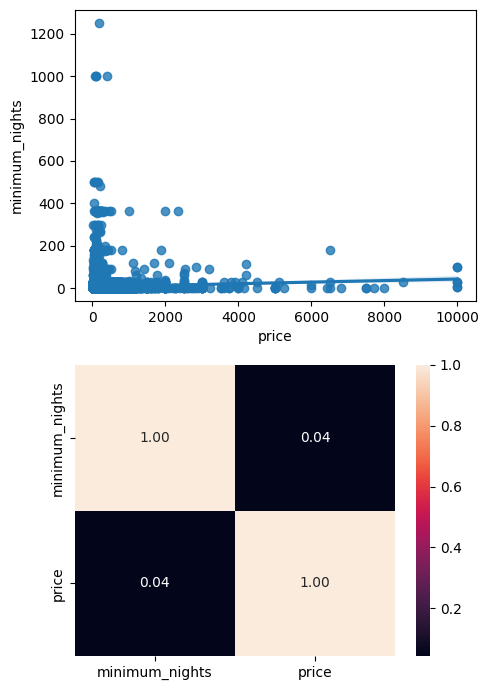

In [19]:
fig, axis = plt.subplots(2, 1, figsize = (5, 7))

sns.regplot(ax = axis[0], data = df, x = "price", y = "minimum_nights")
sns.heatmap(df[["minimum_nights", "price"]].corr(), annot = True, fmt = ".2f", ax = axis[1])

plt.tight_layout()

plt.show()

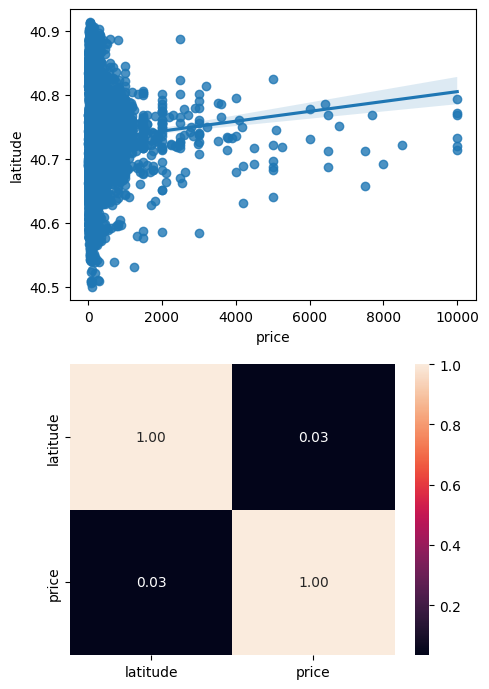

In [20]:
fig, axis = plt.subplots(2, 1, figsize = (5, 7))

sns.regplot(ax = axis[0], data = df, x = "price", y = "latitude")
sns.heatmap(df[["latitude", "price"]].corr(), annot = True, fmt = ".2f", ax = axis[1])

plt.tight_layout()

plt.show()

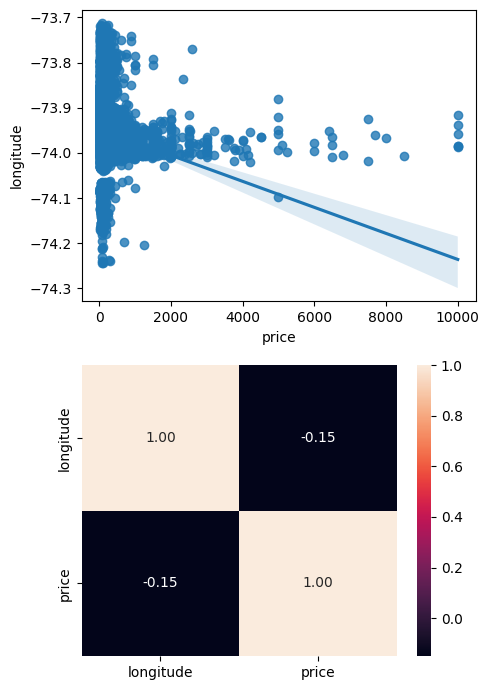

In [21]:
fig, axis = plt.subplots(2, 1, figsize = (5, 7))

sns.regplot(ax = axis[0], data = df, x = "price", y = "longitude")
sns.heatmap(df[["longitude", "price"]].corr(), annot = True, fmt = ".2f", ax = axis[1])

plt.tight_layout()

plt.show()

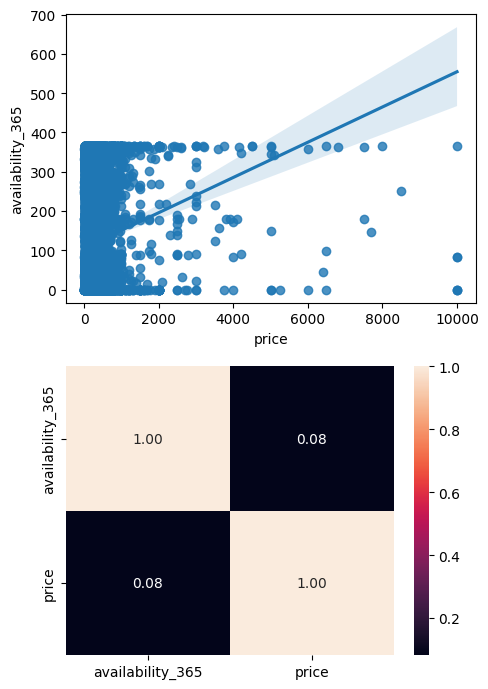

In [22]:
fig, axis = plt.subplots(2, 1, figsize = (5, 7))

sns.regplot(ax = axis[0], data = df, x = "price", y = "availability_365")
sns.heatmap(df[["availability_365", "price"]].corr(), annot = True, fmt = ".2f", ax = axis[1])

plt.tight_layout()

plt.show()


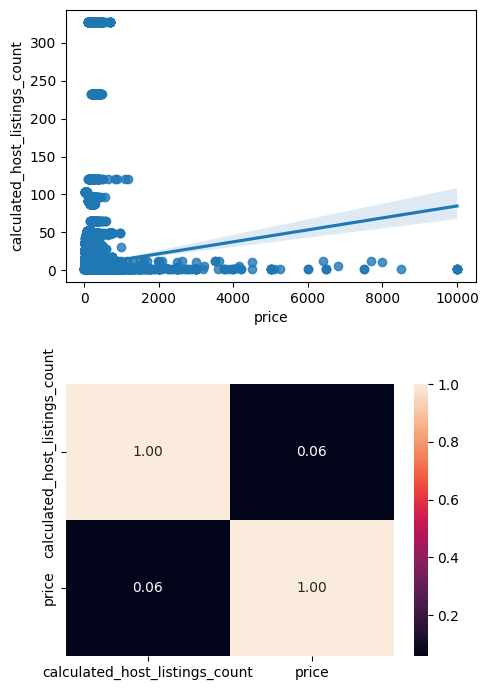

In [23]:
fig, axis = plt.subplots(2, 1, figsize = (5, 7))

sns.regplot(ax = axis[0], data = df, x = "price", y = "calculated_host_listings_count")
sns.heatmap(df[["calculated_host_listings_count", "price"]].corr(), annot = True, fmt = ".2f", ax = axis[1])
axis[1].set_yticklabels(axis[1].get_yticklabels(), rotation=90) 

plt.tight_layout()

plt.show()


### Todas las comparaciones arrojan datos similares en cuanto a la correlación con el precio


#### Visualizacion por tipo de habitación y zona, donce se evidencia en primer lugar que en Brooklyn predomina el tipo de habitación privada, seguido de Manhattan donde la mayor incidencia es para casa completa.

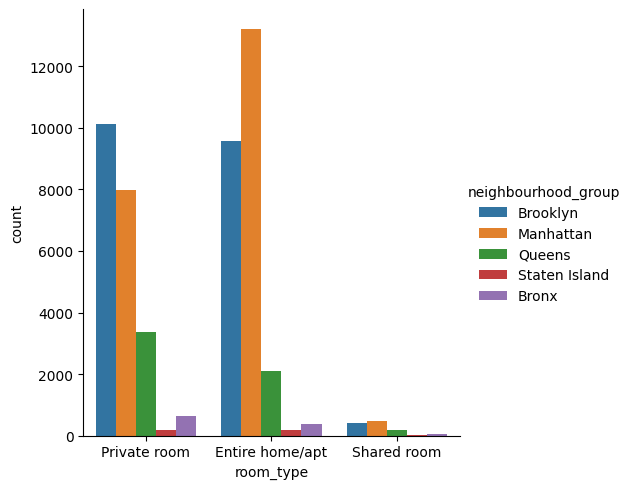

In [24]:
sns.catplot(data=df, x="room_type", hue="neighbourhood_group", kind="count")

### Factorizamos los valores de tipo de habitacion y vecindario para poder estudiar su correlacion en un mapa de calor

In [25]:
df["room_type_n"] = pd.factorize(df["room_type"])[0]
df["neighbourhood_group_n"] = pd.factorize(df["neighbourhood_group"])[0]
df["neighbourhood_n"] = pd.factorize(df["neighbourhood"])[0]

df_lim = df.drop(["room_type","neighbourhood_group","neighbourhood"], axis = 1)

In [26]:
df_corr = df_lim.corr()
df_corr.style.background_gradient(cmap='coolwarm').format(precision=2)

,latitude,longitude,price,minimum_nights,calculated_host_listings_count,availability_365,room_type_n,neighbourhood_group_n,neighbourhood_n
latitude,1.00,0.08,0.03,0.02,0.02,-0.01,-0.00,0.53,-0.14
longitude,0.08,1.00,-0.15,-0.06,-0.11,0.08,-0.16,0.28,0.34
price,0.03,-0.15,1.00,0.04,0.06,0.08,0.21,0.00,-0.05
minimum_nights,0.02,-0.06,0.04,1.00,0.13,0.14,0.07,-0.00,-0.03
calculated_host_listings_count,0.02,-0.11,0.06,0.13,1.00,0.23,0.10,0.04,0.00
availability_365,-0.01,0.08,0.08,0.14,0.23,1.00,0.03,0.12,0.12
room_type_n,-0.00,-0.16,0.21,0.07,0.10,0.03,1.00,-0.00,-0.03
neighbourhood_group_n,0.53,0.28,0.00,-0.00,0.04,0.12,-0.00,1.00,0.49
neighbourhood_n,-0.14,0.34,-0.05,-0.03,0.00,0.12,-0.03,0.49,1.00


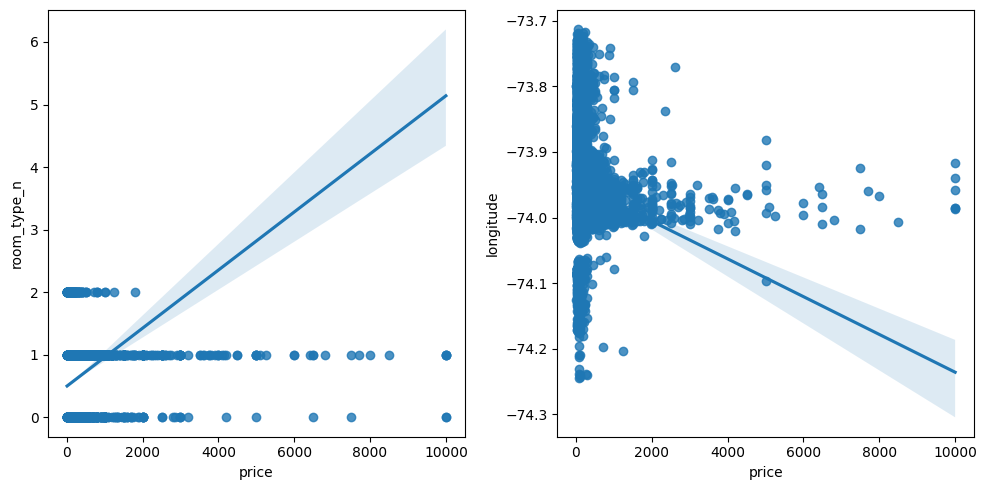

In [27]:
fig, axis = plt.subplots(figsize = (10, 5), ncols = 2)

sns.regplot(ax = axis[0], data = df_lim, x = "price", y = "room_type_n")
sns.regplot(ax = axis[1], data = df_lim, x = "price", y = "longitude")

plt.tight_layout()

plt.show()

### Esto nos indica que la variable con mayor impacto en el precio es la variable de tipo de habitación, algo que tiene mucho sentido, el resto de correlaciones se mantienen bajas como fue visto con anterioridad.

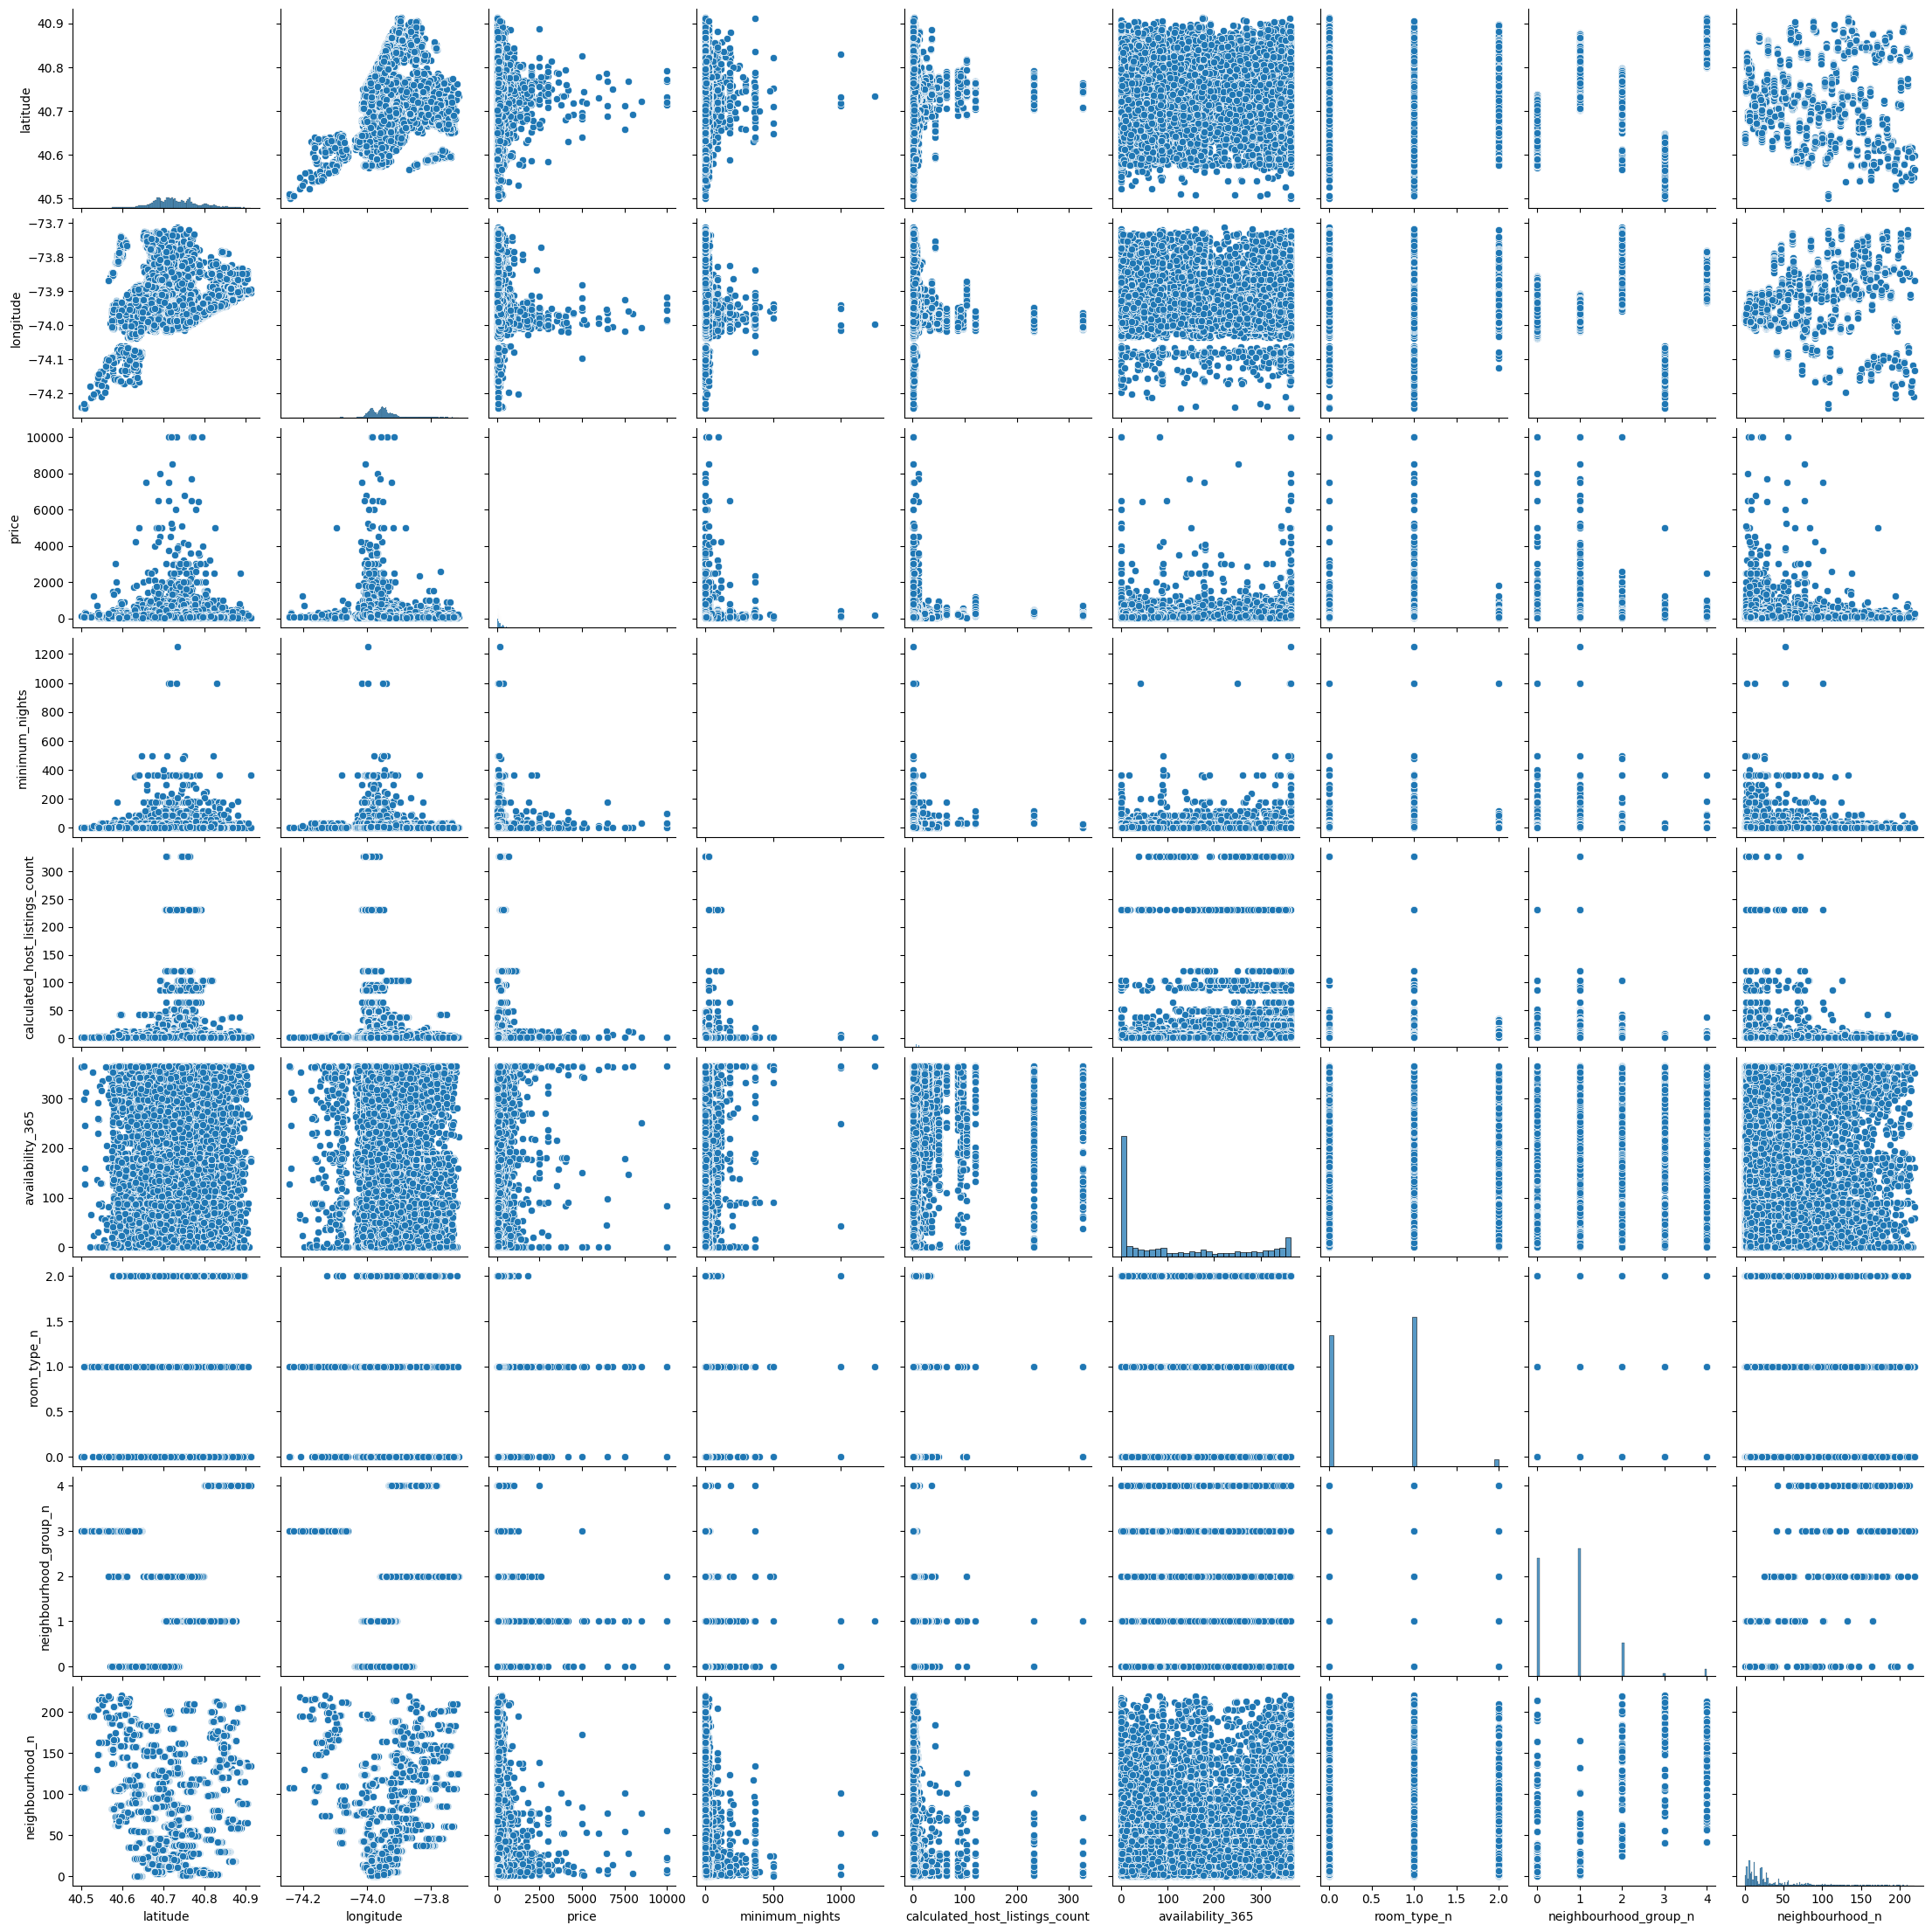

In [28]:
sns.pairplot(data = df)

Validacion de valores Nans

In [29]:
df[df.isna().any(axis=1)].head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,calculated_host_listings_count,availability_365,room_type_n,neighbourhood_group_n,neighbourhood_n


Valida de manera visual, valores faltantes.

<Axes: >

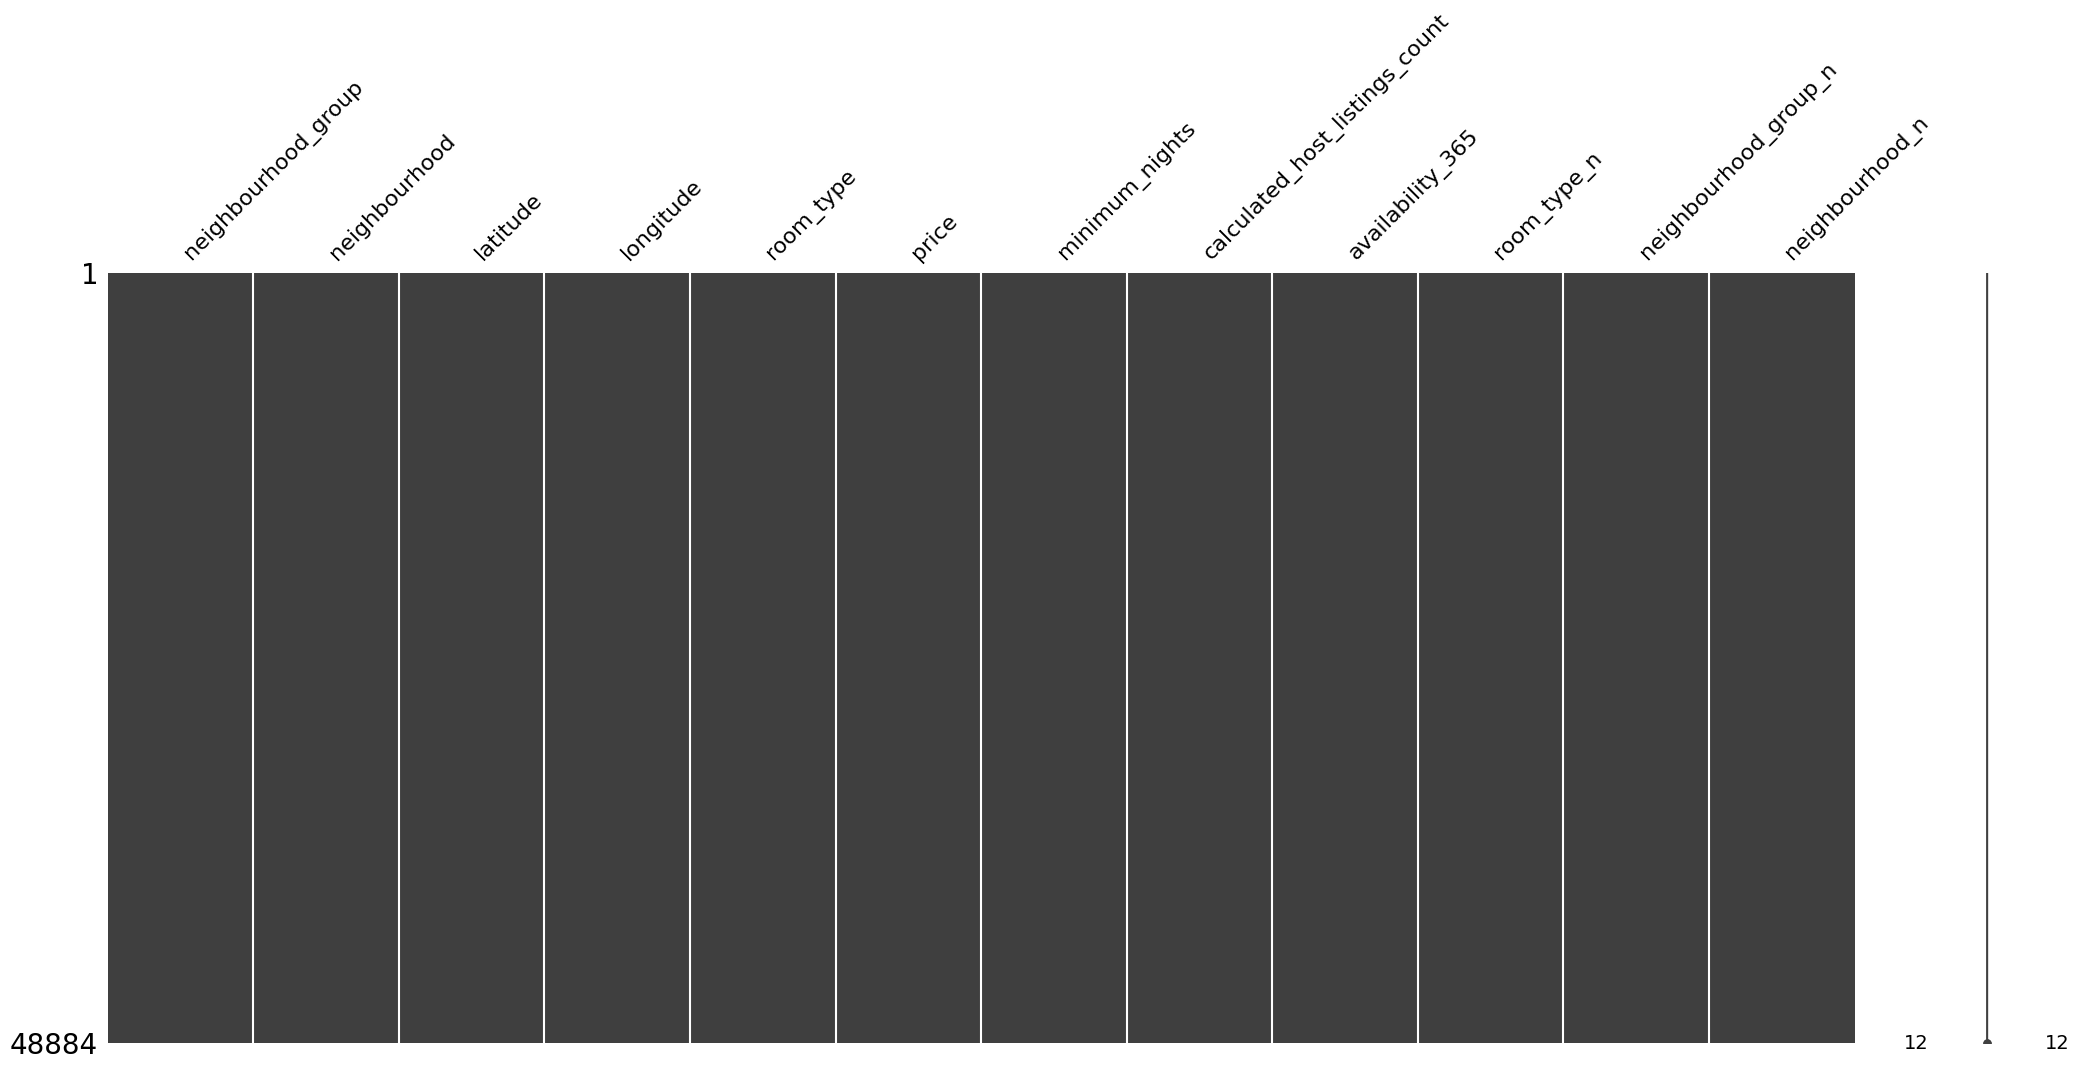

In [30]:
msno.matrix(df)

Determinamos si hay columnas con valores de solo 1 y 0. (Binarias)


In [31]:
columnas_binarias = df[(df==0)|(df==1)].dropna(axis=1).columns
columnas_binarias

Index([], dtype='object')

In [32]:
df_lim

,latitude,longitude,price,minimum_nights,calculated_host_listings_count,availability_365,room_type_n,neighbourhood_group_n,neighbourhood_n
0,40.65,-73.97,149,1,6,365,0,0,0
1,40.75,-73.98,225,1,2,355,1,1,1
2,40.81,-73.94,150,3,1,365,0,1,2
3,40.69,-73.96,89,1,1,194,1,0,3
4,40.80,-73.94,80,10,1,0,1,1,4
...,...,...,...,...,...,...,...,...,...
48890,40.68,-73.95,70,2,2,9,0,0,6
48891,40.70,-73.93,40,4,2,36,0,0,21
48892,40.81,-73.95,115,10,1,27,1,1,2
48893,40.76,-73.99,55,1,6,2,2,1,7


Validamos la descripcion de la columna precio, ya que posee muchos datos anomalos

In [33]:
precio_estimado = df_lim["price"].describe()
precio_estimado

count   48884.00
mean      152.76
std       240.17
min        10.00
25%        69.00
50%       106.00
75%       175.00
max     10000.00
Name: price, dtype: float64

In [34]:
precio_iqr = precio_estimado["75%"] - precio_estimado["25%"]
upper_limit = precio_estimado["75%"] + 1.5 * precio_iqr
lower_limit = precio_estimado["25%"] - 1.5 * precio_iqr

print(f"Los límites superior e inferior para la búsqueda de outliers son {round(upper_limit, 2)} y {round(lower_limit, 2)}, con un rango intercuartílico de {round(precio_iqr, 2)}")

Los límites superior e inferior para la búsqueda de outliers son 334.0 y -90.0, con un rango intercuartílico de 106.0


In [35]:
df_lim.apply(lambda x: x.skew())

latitude                          0.24
longitude                         1.28
price                            19.12
minimum_nights                   21.83
calculated_host_listings_count    7.93
availability_365                  0.76
room_type_n                       0.18
neighbourhood_group_n             1.38
neighbourhood_n                   2.25
dtype: float64

### Procedemos a eliminar los valores que son anomalos en las variables precio y minimo de noches.

In [36]:
df_filtrado = df_lim.drop(df_lim[(df_lim['price'] > 2000) | (df_lim['minimum_nights'] > 300)].index)
df_filtrado.describe()


,latitude,longitude,price,minimum_nights,calculated_host_listings_count,availability_365,room_type_n,neighbourhood_group_n,neighbourhood_n
count,48749.00,48749.00,48749.00,48749.00,48749.00,48749.00,48749.00,48749.00,48749.00
mean,40.73,-73.95,145.46,6.55,7.16,112.49,0.57,0.79,29.89
std,0.05,0.05,139.62,13.22,33.00,131.48,0.54,0.84,34.68
min,40.50,-74.24,10.00,1.00,1.00,0.00,0.00,0.00,0.00
25%,40.69,-73.98,69.00,1.00,1.00,0.00,0.00,0.00,7.00
50%,40.72,-73.96,105.00,3.00,1.00,44.00,1.00,1.00,19.00
75%,40.76,-73.94,175.00,5.00,2.00,226.00,1.00,1.00,37.00
max,40.91,-73.71,2000.00,300.00,327.00,365.00,2.00,4.00,220.00


Validamos que no tengamos valores faltantes.

In [37]:
df_filtrado.isnull().sum().sort_values()

latitude                          0
longitude                         0
price                             0
minimum_nights                    0
calculated_host_listings_count    0
availability_365                  0
room_type_n                       0
neighbourhood_group_n             0
neighbourhood_n                   0
dtype: int64

Valores con una proporcion menor de asimetria

In [38]:
df_filtrado.apply(lambda x: x.skew())

latitude                         0.24
longitude                        1.28
price                            4.88
minimum_nights                   7.84
calculated_host_listings_count   7.92
availability_365                 0.77
room_type_n                      0.18
neighbourhood_group_n            1.38
neighbourhood_n                  2.25
dtype: float64

In [39]:
df_filtrado.shape

(48749, 9)

## Luego de filtrar los datos, evidenciamos que eliminamos en total 146 registros.

In [40]:
df_filtrado.isna().sum()

latitude                          0
longitude                         0
price                             0
minimum_nights                    0
calculated_host_listings_count    0
availability_365                  0
room_type_n                       0
neighbourhood_group_n             0
neighbourhood_n                   0
dtype: int64

Factor de inflación de la varianza (VIF)

In [41]:
vif = pd.Series([variance_inflation_factor(df_filtrado.values, i) for i in range(df_filtrado.shape[1])], index=df_filtrado.columns)
vif

latitude                         778776.07
longitude                        778147.22
price                                 2.43
minimum_nights                        1.34
calculated_host_listings_count        1.15
availability_365                      1.93
room_type_n                           2.39
neighbourhood_group_n                 4.43
neighbourhood_n                       2.76
dtype: float64

#### Observamos que  el VIF más alto es neighbourhood_group_n con un valor de 4.43. Esto significa que esta variable está bastante correlacionada con las demás, y que su coeficiente de regresión puede tener una varianza elevada. 

## Escalar los valores de nuestro Dataframe

In [42]:
scaler = MinMaxScaler()

df_escalado = scaler.fit_transform(df_filtrado)
df_escalado = pd.DataFrame(df_escalado, columns= df_filtrado.columns)
df_escalado

,latitude,longitude,price,minimum_nights,calculated_host_listings_count,availability_365,room_type_n,neighbourhood_group_n,neighbourhood_n
0,0.36,0.51,0.07,0.00,0.02,1.00,0.00,0.00,0.00
1,0.61,0.49,0.11,0.00,0.00,0.97,0.50,0.25,0.00
2,0.75,0.57,0.07,0.01,0.00,1.00,0.00,0.25,0.01
3,0.45,0.54,0.04,0.00,0.00,0.53,0.50,0.00,0.01
4,0.72,0.57,0.04,0.03,0.00,0.00,0.50,0.25,0.02
...,...,...,...,...,...,...,...,...,...
48744,0.43,0.55,0.03,0.00,0.00,0.02,0.00,0.00,0.03
48745,0.49,0.59,0.02,0.01,0.00,0.10,0.00,0.00,0.10
48746,0.76,0.56,0.05,0.03,0.00,0.07,0.50,0.25,0.01
48747,0.62,0.48,0.02,0.00,0.02,0.01,1.00,0.25,0.03


In [50]:
df_escalado.to_csv("/workspaces/machine-learning/data/processed/data_limpia.csv")
.